In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def test_parameters(parameters):

    time_start = parameters['time_start']
    time_end = parameters['time_end']
    time_step = parameters['time_step']
    tolerance = parameters['tolerance']
    S0 = parameters['S0']
    R0 = parameters['R0']
    growth_rate_S = parameters['growth_rate_S']
    growth_rate_R = parameters['growth_rate_R']
    carrying_capacity = parameters['carrying_capacity']
    maximum_tollerated_dose = parameters['maximum_tollerated_dose']
    death_rate_S = parameters['death_rate_S']
    death_rate_R = parameters['death_rate_R']
    division_rate = parameters['division_rate']
    therapy_type = parameters['therapy_type']
    current_state = parameters['current_state']
    adaptive_therapy_ratio = parameters['adaptive_therapy_ratio']

    assert time_start >= 0
    assert time_end > time_start
    assert time_step > 0
    assert tolerance > 0
    assert S0 >= 0
    assert R0 >= 0
    assert growth_rate_S > 0
    assert growth_rate_R > 0
    assert carrying_capacity > 0
    assert maximum_tollerated_dose > 0
    assert death_rate_S > 0
    assert death_rate_S < 1
    assert death_rate_R > 0
    assert death_rate_R < 1
    assert division_rate > 0
    assert division_rate < 1
    assert therapy_type == 'continuous' or therapy_type == 'adaptive' or therapy_type == 'notherapy'
    assert adaptive_therapy_ratio > 0
    assert adaptive_therapy_ratio < 1
    assert current_state == 0 or current_state == 1


    print("All tests passed")

    return

## Drug concentration function

The function takes in N, the total number of cells, and the parameters. It takes in the therapy type defined by the user, which can be chosen as either 'continuous', 'adaptive', or 'notherapy'. It takes in the maximum tolerated dose of the drug which is ______. Depending on the input chosen by the user, the function then turns on the drug as instructed. 

The most interesting case is when the user chooses adaptive therapy. In this case we first calculate the initial number of tumour cells and then compare it to the total number at the given time. Therapy is switched on when N>N_0 * adaptive_therapy_ratio, where adaptive_therapy_ratio is usually chosen to be 50% but can be varied.

In [4]:
def therapy_drug_concentration(N, parameters):
    'funcskjdghfkasjhf'

    therapy_type = parameters['therapy_type']
    maximum_tollerated_dose = parameters['maximum_tollerated_dose']

    if therapy_type == 'continuous':
        return maximum_tollerated_dose
    if therapy_type == 'notherapy':
        return 0
    elif therapy_type == 'adaptive':
        N0 = parameters['S0'] + parameters['R0']
        adaptive_therapy_ratio = parameters['adaptive_therapy_ratio']
        current_state = parameters['current_state']
        # on therapy
        if current_state == 1:
            # if shrunk sufficiently, turn off therapy
            if N < N0 * adaptive_therapy_ratio:
                parameters['current_state'] = 0
                return 0
            else:
            # else, keep on therapy
                return maximum_tollerated_dose
        # off therapy
        else:
            # if grown sufficiently, turn on therapy
            if N > N0:
                parameters['current_state'] = 1
                return maximum_tollerated_dose
            else:
            # else, keep off therapy
                return 0

## One step function
Talk about adaptive timestep method

In [5]:
def one_step(S, R, time_step, parameters):

    growth_rate_S = parameters['growth_rate_S']
    growth_rate_R = parameters['growth_rate_R']
    carrying_capacity = parameters['carrying_capacity']
    maximum_tollerated_dose = parameters['maximum_tollerated_dose']
    death_rate_S = parameters['death_rate_S']
    death_rate_R = parameters['death_rate_R']
    division_rate = parameters['division_rate']
    
    N = S + R
    
    ##########################
   # parameters['carrying_capacity']= carrying_capacity + 0.1
   # print(parameters['carrying_capacity'])
   # print(time_step)
    
   # current_carrying_capacity = N / parameters['carrying_capacity']
    ##########################
    
    current_carrying_capacity = N / carrying_capacity

    D = therapy_drug_concentration(N, parameters)/maximum_tollerated_dose
    
    effective_growth_rate_S = growth_rate_S * (1 - current_carrying_capacity) * (1 - 2*division_rate*D)
    effective_growth_rate_R = growth_rate_R * (1 - current_carrying_capacity)

    dS = effective_growth_rate_S * S - death_rate_S * S
    dR = effective_growth_rate_R * R - death_rate_R * R

    S1 = S + dS * time_step
    R1 = R + dR * time_step

    return [S1, R1, D]

## Two step function

In [6]:
def two_step(S, R, time_step, parameters):
    
    SR1 = one_step(S, R, time_step/2, parameters)
    SR2 = one_step(SR1[0], SR1[1], time_step/2, parameters)

    return SR2

## Main code

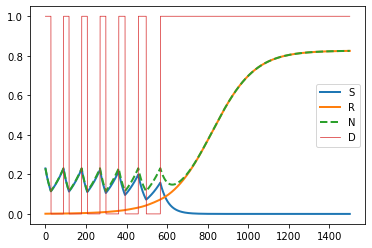

In [7]:
def ode_model(parameters, verbose=False):


    time_step = parameters['time_step']
    tolerance = parameters['tolerance']

    time_start = parameters['time_start']
    time_end = parameters['time_end']

    S0 = parameters['S0']
    R0 = parameters['R0']
    N0 = S0 + R0
    D0 = 1


    initial_size = int((time_end - time_start) / time_step)

    # Initialize arrays
    S = np.zeros(initial_size)
    R = np.zeros(initial_size)
    N = np.zeros(initial_size)
    T = np.zeros(initial_size)
    D = np.zeros(initial_size)

    current_time = time_start
    current_index = 0

    S[current_index] = S0
    R[current_index] = R0
    N[current_index] = N0
    T[current_index] = current_time
    D[current_index] = D0

    while current_time + time_step < time_end:

        
        SR_1 = one_step(S[current_index], R[current_index], time_step, parameters)
        SR_2 = two_step(S[current_index], R[current_index], time_step, parameters)
        
        error = abs(SR_1[0] - SR_2[0]) + abs(SR_1[1] - SR_2[1])

        if verbose == True:
            print("Error: ", error)
            print("Time step: ", time_step)
            print("Current time: ", current_time)
            print("Tolerance: ", tolerance)
            print("")

        if error < 10 * tolerance:
            S[current_index + 1] = SR_2[0]
            R[current_index + 1] = SR_2[1]
            N[current_index + 1] = S[current_index + 1] + R[current_index + 1]
            T[current_index + 1] = current_time + time_step
            D[current_index + 1] = SR_2[2]
            current_time += time_step
            current_index += 1
            # time_step = time_step/2
        elif error < tolerance:
            S[current_index + 1] = SR_2[0]
            R[current_index + 1] = SR_2[1]
            N[current_index + 1] = S[current_index + 1] + R[current_index + 1]
            T[current_index + 1] = current_time + time_step
            D[current_index + 1] = SR_2[2]
            current_time += time_step
            current_index += 1
        else:
            time_step = time_step/2
        
        if current_index == len(S) - 1:
            S = np.concatenate((S, np.zeros(len(S))))
            R = np.concatenate((R, np.zeros(len(R))))
            N = np.concatenate((N, np.zeros(len(N))))
            T = np.concatenate((T, np.zeros(len(T))))
            D = np.concatenate((D, np.zeros(len(D))))

    SR = two_step(S[current_index], R[current_index], time_end - current_time, parameters)
    S[current_index + 1] = SR[0]
    R[current_index + 1] = SR[1]
    N[current_index + 1] = S[current_index + 1] + R[current_index + 1]
    T[current_index + 1] = time_end
    current_index += 1

    return S[:current_index], R[:current_index], N[:current_index], T[:current_index], D[:current_index]
       

if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1500,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.001,
        'growth_rate_S': 0.027,
        'S0': 0.23,
        'growth_rate_R': 0.023,
        #0.023
        'carrying_capacity': 2,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0135,
        #0.013
        'death_rate_R': 0.0135,
        #0.013
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S, R, N, T, D = ode_model(parameters, verbose=False)

    plt.plot(T, S, label='S',linewidth=2)
    plt.plot(T, R, label='R',linewidth=2)
    plt.plot(T, N, label='N', linestyle='--',linewidth=2)
    plt.plot(T, D, label='D',linewidth=.7)
    plt.legend()
    plt.show()

In [8]:
# compute the time to progression
ttpa = 0
threshold=1.5
for i in range(len(D)):
    if S[i] + R[i] > threshold * (S[0] + R[0]):
        ttpa = i
        break

In [9]:
print('the time at which N=1.5*N0 is',T[ttpa])

the time at which N=1.5*N0 is 785.9000000001101


In [10]:
A=np.round(np.sum(D[:ttpa]*T[:ttpa]))
print("The area beneath the curve is approximately", A)

The area beneath the curve is approximately 1956217.0


In [11]:
T[ttpa]

785.9000000001101

# Creating a figure for presentation

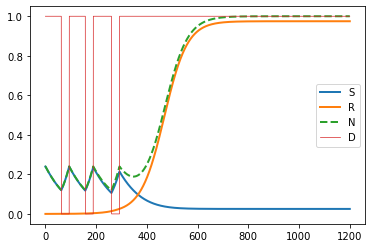

In [267]:
#COLLECT DATA FOR PLOT 1
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.0001,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S1, R1, N1, T1, D1 = ode_model(parameters, verbose=False)

    plt.plot(T1, S1, label='S',linewidth=2)
    plt.plot(T1, R1, label='R',linewidth=2)
    plt.plot(T1, N1, label='N', linestyle='--',linewidth=2)
    plt.plot(T1, D1, label='D',linewidth=.7)
    plt.legend()
    plt.show()

In [268]:
# compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D)):
    if S1[i] + R1[i] > threshold * (S1[0] + R1[0]):
        ttpa = i
        break
        
print('ttp is', T1[ttpa])

ttp is 413.3000000000255


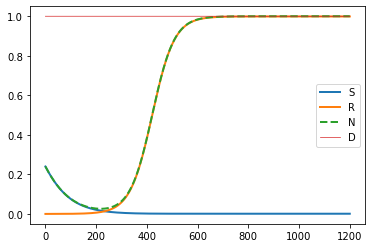

ttpc is 381.2000000000182
ttp difference is 32.1000000000073


In [269]:
#Continuous therapy
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.0001,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc1, Rc1, Nc1, Tc1, Dc1 = ode_model(parameters, verbose=False)
    plt.plot(Tc1, Sc1, label='S',linewidth=2)
    plt.plot(Tc1, Rc1, label='R',linewidth=2)
    plt.plot(Tc1, Nc1, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc1, Dc1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(D1)):
    if Sc1[i] + Rc1[i] > threshold * (Sc1[0] + Rc1[0]):
        ttpc = i
        break
        
diff1=T1[ttpa]-Tc1[ttpc]
print('ttpc is', Tc1[ttpc])
print('ttp difference is', diff1)

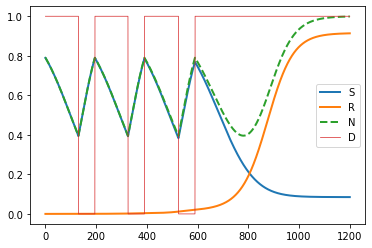

In [270]:
#COLLECT DATA FOR PLOT 2
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.0001,
        'growth_rate_S': 0.027,
        'S0': 0.79,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S2, R2, N2, T2, D2 = ode_model(parameters, verbose=False)

    plt.plot(T2, S2, label='S',linewidth=2)
    plt.plot(T2, R2, label='R',linewidth=2)
    plt.plot(T2, N2, label='N', linestyle='--',linewidth=2)
    plt.plot(T2, D2, label='D',linewidth=.7)
    plt.legend()
    plt.show()

In [271]:
# compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D2)):
    if S2[i] + R2[i] > threshold * (S2[0] + R2[0]):
        ttpa = i
        break
        
print('ttp is', T2[ttpa])

ttp is 1012.7000000001617


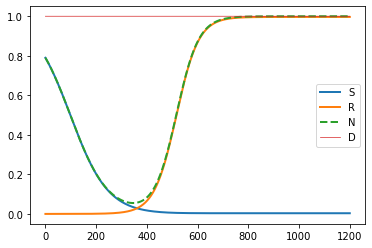

ttpc is 643.2000000000777
ttp difference is 369.500000000084


In [272]:
#Continuous therapy 2
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.0001,
        'growth_rate_S': 0.027,
        'S0': 0.79,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc2, Rc2, Nc2, Tc2, Dc2 = ode_model(parameters, verbose=False)
    plt.plot(Tc2, Sc2, label='S',linewidth=2)
    plt.plot(Tc2, Rc2, label='R',linewidth=2)
    plt.plot(Tc2, Nc2, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc2, Dc2, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(D2)):
    if Sc2[i] + Rc2[i] > threshold * (Sc2[0] + Rc2[0]):
        ttpc = i
        break
        
diff2=T2[ttpa]-Tc2[ttpc]
print('ttpc is', Tc2[ttpc])
print('ttp difference is', diff2)

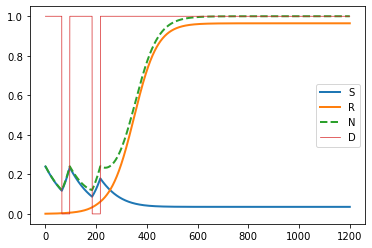

In [273]:
#COLLECT DATA FOR PLOT 3
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.001,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S3, R3, N3, T3, D3 = ode_model(parameters, verbose=False)

    plt.plot(T3, S3, label='S',linewidth=2)
    plt.plot(T3, R3, label='R',linewidth=2)
    plt.plot(T3, N3, label='N', linestyle='--',linewidth=2)
    plt.plot(T3, D3, label='D',linewidth=.7)
    plt.legend()
    plt.show()

In [274]:
# compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D3)):
    if S3[i] + R3[i] > threshold * (S3[0] + R3[0]):
        ttpa = i
        break
        
print('ttp is', T3[ttpa])

ttp is 284.1999999999961


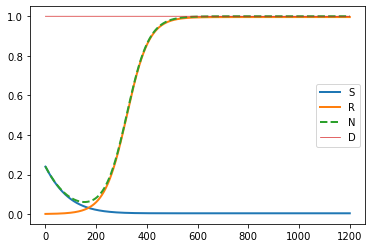

ttpc is 279.7999999999951
ttp difference is 4.4000000000010004


In [275]:
#Continuous therapy 3
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.001,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc3, Rc3, Nc3, Tc3, Dc3 = ode_model(parameters, verbose=False)
    plt.plot(Tc3, Sc3, label='S',linewidth=2)
    plt.plot(Tc3, Rc3, label='R',linewidth=2)
    plt.plot(Tc3, Nc3, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc3, Dc3, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(D3)):
    if Sc3[i] + Rc3[i] > threshold * (Sc3[0] + Rc3[0]):
        ttpc = i
        break
        
diff3=T3[ttpa]-Tc3[ttpc]
print('ttpc is', Tc3[ttpc])
print('ttp difference is', diff3)

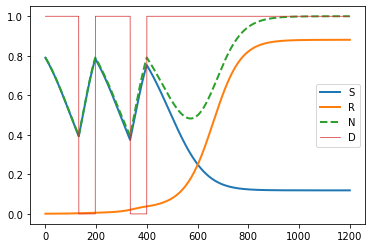

In [276]:
#COLLECT DATA FOR PLOT 4
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.001,
        'growth_rate_S': 0.027,
        'S0': 0.79,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S4, R4, N4, T4, D4 = ode_model(parameters, verbose=False)

    plt.plot(T4, S4, label='S',linewidth=2)
    plt.plot(T4, R4, label='R',linewidth=2)
    plt.plot(T4, N4, label='N', linestyle='--',linewidth=2)
    plt.plot(T4, D4, label='D',linewidth=.7)
    plt.legend()
    plt.show()

In [277]:
# compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D4)):
    if S4[i] + R4[i] > threshold * (S4[0] + R4[0]):
        ttpa = i
        break
        
print('ttp is', T4[ttpa])

ttp is 803.7000000001142


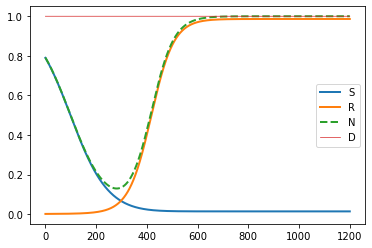

ttpc is 546.1000000000556
ttp difference is 257.60000000005857


In [278]:
#Continuous therapy 4
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.001,
        'growth_rate_S': 0.027,
        'S0': 0.79,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc4, Rc4, Nc4, Tc4, Dc4 = ode_model(parameters, verbose=False)
    plt.plot(Tc4, Sc4, label='S',linewidth=2)
    plt.plot(Tc4, Rc4, label='R',linewidth=2)
    plt.plot(Tc4, Nc4, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc4, Dc4, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(D4)):
    if Sc4[i] + Rc4[i] > threshold * (Sc4[0] + Rc4[0]):
        ttpc = i
        break
        
diff4=T4[ttpa]-Tc4[ttpc]
print('ttpc is', Tc4[ttpc])
print('ttp difference is', diff4)

# Plotting the results

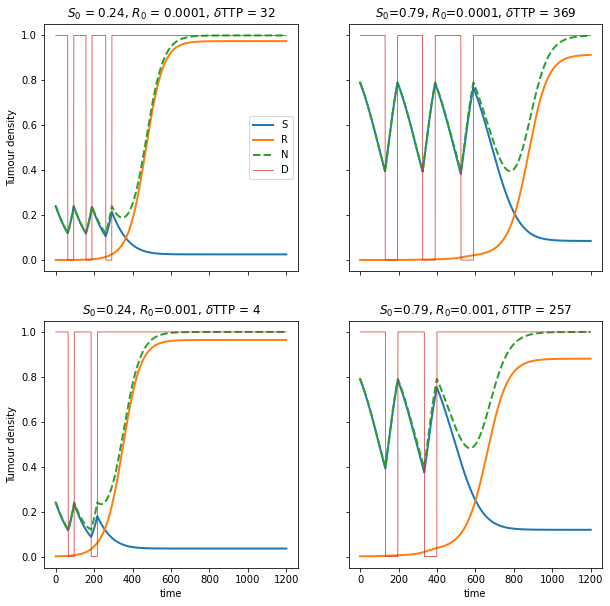

In [281]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(T1, S1, label='S',linewidth=2)
axs[0, 0].plot(T1, R1, label='R',linewidth=2)
axs[0, 0].plot(T1, N1, label='N', linestyle='--',linewidth=2)
axs[0, 0].plot(T1, D1, label='D',linewidth=.7)
axs[0, 0].legend()
axs[0, 0].set_title('$S_0$ = 0.24, $R_0$ = 0.0001, $\delta$TTP = %d'% diff1)
axs[0, 1].plot(T2, S2, label='S',linewidth=2)
axs[0, 1].plot(T2, R2, label='R',linewidth=2)
axs[0, 1].plot(T2, N2, label='N', linestyle='--',linewidth=2)
axs[0, 1].plot(T2, D2, label='D',linewidth=.7)
axs[0, 1].set_title('$S_0$=0.79, $R_0$=0.0001, $\delta$TTP = %d'% diff2)
axs[1, 0].plot(T3, S3, label='S',linewidth=2)
axs[1, 0].plot(T3, R3, label='R',linewidth=2)
axs[1, 0].plot(T3, N3, label='N', linestyle='--',linewidth=2)
axs[1, 0].plot(T3, D3, label='D',linewidth=.7)
axs[1, 0].set_title('$S_0$=0.24, $R_0$=0.001, $\delta$TTP = %d'% diff3)
axs[1, 1].plot(T4, S4, label='S',linewidth=2)
axs[1, 1].plot(T4, R4, label='R',linewidth=2)
axs[1, 1].plot(T4, N4, label='N', linestyle='--',linewidth=2)
axs[1, 1].plot(T4, D4, label='D',linewidth=.7)
axs[1, 1].set_title('$S_0$=0.79, $R_0$=0.001, $\delta$TTP = %d'% diff4)
fig.set_figheight(10)
fig.set_figwidth(10)
#fig, axs = plt.subplots(2, 2, figsize=(30,30))

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='Tumour density')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


plt.savefig('density.png')

# Second plot

In [283]:
#initial density n0=0.35 and resistance is 0.1% of this
if __name__ == "__main__":

    # Define parameters

    parameters35_p1 = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.0001,
        'growth_rate_S': 0.027,
        'S0': 0.35,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S35, R35, N35, T35, D35 = ode_model(parameters35_p1, verbose=False)
    ttpa = 0
    threshold=1.2
for i in range(len(D35)):
    if S35[i] + R35[i] > threshold * (S35[0] + R35[0]):
        ttpa = i
        break
        
print('ttpa is', T35[ttpa])

#continuous model
if __name__ == "__main__":

    # Define parameters

    parameters35_p1_c = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.0001,
        'growth_rate_S': 0.027,
        'S0': 0.35,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S35c, R35c, N35c, T35c, D35c = ode_model(parameters35_p1_c, verbose=False)
    ttpc = 0
    threshold=1.2
for i in range(len(D35)):
    if S35c[i] + R35c[i] > threshold * (S35c[0] + R35c[0]):
        ttpc = i
        break
        
print('ttpc is', T35c[ttpc])
diff5=T35[ttpa]-T35c[ttpc]
print('difference is',diff5)

ttpa is 484.6000000000417
ttpc is 418.2000000000266
difference is 66.4000000000151


In [292]:
#initial density n0=0.35 and resistance is 1% of this
if __name__ == "__main__":

    # Define parameters

    parameters35_1 = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.001,
        'growth_rate_S': 0.027,
        'S0': 0.35,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S351, R351, N351, T351, D351 = ode_model(parameters35_1, verbose=False)
    ttpa = 0
    threshold=1.2
for i in range(len(D351)):
    if S351[i] + R351[i] > threshold * (S351[0] + R351[0]):
        ttpa = i
        break
        
print('ttpa is', T351[ttpa])

#continuous model
if __name__ == "__main__":

    # Define parameters

    parameters35_1_c = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.001,
        'growth_rate_S': 0.027,
        'S0': 0.35,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S35c1, R35c1, N35c1, T35c1, D35c1 = ode_model(parameters35_1_c, verbose=False)
    ttpc = 0
    threshold=1.2
for i in range(len(D351)):
    if S35c1[i] + R35c1[i] > threshold * (S35c1[0] + R35c1[0]):
        ttpc = i
        break
        
print('ttpc is', T35c1[ttpc])
diff9=T351[ttpa]-T35c1[ttpc]
print('difference is',diff9)

ttpa is 349.50000000001097
ttpc is 317.1000000000036
difference is 32.40000000000737


In [284]:
#
if __name__ == "__main__":

    # Define parameters

    parameters46_p1 = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.0001,
        'growth_rate_S': 0.027,
        'S0': 0.46,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S46, R46, N46, T46, D46 = ode_model(parameters46_p1, verbose=False)
    ttpa = 0
    threshold=1.2
for i in range(len(D46)):
    if S46[i] + R46[i] > threshold * (S46[0] + R46[0]):
        ttpa = i
        break
        
print('ttpa is', T46[ttpa])

#continuous model
if __name__ == "__main__":

    # Define parameters

    parameters46_p1_c = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.0001,
        'growth_rate_S': 0.027,
        'S0': 0.46,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S46c, R46c, N46c, T46c, D46c = ode_model(parameters46_p1_c, verbose=False)
    ttpc = 0
    threshold=1.2
for i in range(len(D46)):
    if S46c[i] + R46c[i] > threshold * (S46c[0] + R46c[0]):
        ttpc = i
        break
        
print('ttpc is', T46c[ttpc])
diff6=T46[ttpa]-T46c[ttpc]
print('difference is',diff6)

ttpa is 564.1000000000597
ttpc is 455.200000000035
difference is 108.9000000000247


In [293]:
#S0 46 R0 1
if __name__ == "__main__":

    # Define parameters

    parameters46_1 = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.001,
        'growth_rate_S': 0.027,
        'S0': 0.46,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S461, R461, N461, T461, D461 = ode_model(parameters46_1, verbose=False)
    ttpa = 0
    threshold=1.2
for i in range(len(D461)):
    if S461[i] + R461[i] > threshold * (S461[0] + R461[0]):
        ttpa = i
        break
        
print('ttpa is', T461[ttpa])

#continuous model
if __name__ == "__main__":

    # Define parameters

    parameters46_1_c = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.001,
        'growth_rate_S': 0.027,
        'S0': 0.46,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S46c1, R46c1, N46c1, T46c1, D46c1 = ode_model(parameters46_1_c, verbose=False)
    ttpc = 0
    threshold=1.2
for i in range(len(D46)):
    if S46c1[i] + R46c1[i] > threshold * (S46c1[0] + R46c1[0]):
        ttpc = i
        break
        
print('ttpc is', T46c1[ttpc])
diff10=T461[ttpa]-T46c1[ttpc]
print('difference is',diff10)

ttpa is 418.10000000002657
ttpc is 354.5000000000121
difference is 63.60000000001446


In [285]:
# 57
if __name__ == "__main__":

    # Define parameters

    parameters57_p1 = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.0001,
        'growth_rate_S': 0.027,
        'S0': 0.57,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S57, R57, N57, T57, D57 = ode_model(parameters57_p1, verbose=False)
    ttpa = 0
    threshold=1.2
for i in range(len(D57)):
    if S57[i] + R57[i] > threshold * (S57[0] + R57[0]):
        ttpa = i
        break
        
print('ttpa is', T57[ttpa])

#continuous model
if __name__ == "__main__":

    # Define parameters

    parameters57_p1_c = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.0001,
        'growth_rate_S': 0.027,
        'S0': 0.57,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S57c, R57c, N57c, T57c, D57c = ode_model(parameters57_p1_c, verbose=False)
    ttpc = 0
    threshold=1.2
for i in range(len(D57)):
    if S57c[i] + R57c[i] > threshold * (S57c[0] + R57c[0]):
        ttpc = i
        break
        
print('ttpc is', T57c[ttpc])
diff7=T57[ttpa]-T57c[ttpc]
print('difference is',diff7)

ttpa is 661.6000000000819
ttpc is 496.70000000004444
difference is 164.90000000003744


In [294]:
# 57 r0=1
if __name__ == "__main__":

    # Define parameters

    parameters57_1 = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.001,
        'growth_rate_S': 0.027,
        'S0': 0.57,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S571, R571, N571, T571, D571 = ode_model(parameters57_1, verbose=False)
    ttpa = 0
    threshold=1.2
for i in range(len(D571)):
    if S571[i] + R571[i] > threshold * (S571[0] + R571[0]):
        ttpa = i
        break
        
print('ttpa is', T571[ttpa])

#continuous model
if __name__ == "__main__":

    # Define parameters

    parameters57_1_c = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.001,
        'growth_rate_S': 0.027,
        'S0': 0.57,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S57c1, R57c1, N57c1, T57c1, D57c1 = ode_model(parameters57_1_c, verbose=False)
    ttpc = 0
    threshold=1.2
for i in range(len(D571)):
    if S57c1[i] + R57c1[i] > threshold * (S57c1[0] + R57c1[0]):
        ttpc = i
        break
        
print('ttpc is', T57c1[ttpc])
diff11=T571[ttpa]-T57c1[ttpc]
print('difference is',diff11)

ttpa is 500.9000000000454
ttpc is 396.6000000000217
difference is 104.30000000002372


In [286]:
# 68
if __name__ == "__main__":

    # Define parameters

    parameters68_p1 = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.0001,
        'growth_rate_S': 0.027,
        'S0': 0.68,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S68, R68, N68, T68, D68 = ode_model(parameters68_p1, verbose=False)
    ttpa = 0
    threshold=1.2
for i in range(len(D68)):
    if S68[i] + R68[i] > threshold * (S68[0] + R68[0]):
        ttpa = i
        break
        
print('ttpa is', T68[ttpa])

#continuous model
if __name__ == "__main__":

    # Define parameters

    parameters68_p1_c = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.0001,
        'growth_rate_S': 0.027,
        'S0': 0.68,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S68c, R68c, N68c, T68c, D68c = ode_model(parameters68_p1_c, verbose=False)
    ttpc = 0
    threshold=1.2
for i in range(len(D68)):
    if S68c[i] + R68c[i] > threshold * (S68c[0] + R68c[0]):
        ttpc = i
        break
        
print('ttpc is', T68c[ttpc])
diff8=T68[ttpa]-T68c[ttpc]
print('difference is',diff8)

ttpa is 793.900000000112
ttpc is 550.0000000000565
difference is 243.90000000005546


In [295]:
# 68
if __name__ == "__main__":

    # Define parameters

    parameters68_1 = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.001,
        'growth_rate_S': 0.027,
        'S0': 0.68,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S681, R681, N681, T681, D681 = ode_model(parameters68_1, verbose=False)
    ttpa = 0
    threshold=1.2
for i in range(len(D681)):
    if S681[i] + R681[i] > threshold * (S681[0] + R681[0]):
        ttpa = i
        break
        
print('ttpa is', T681[ttpa])

#continuous model
if __name__ == "__main__":

    # Define parameters

    parameters68_1_c = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.001,
        'growth_rate_S': 0.027,
        'S0': 0.68,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S68c1, R68c1, N68c1, T68c1, D68c1 = ode_model(parameters68_1_c, verbose=False)
    ttpc = 0
    threshold=1.2
for i in range(len(D681)):
    if S68c1[i] + R68c1[i] > threshold * (S68c1[0] + R68c1[0]):
        ttpc = i
        break
        
print('ttpc is', T68c1[ttpc])
diff12=T681[ttpa]-T68c1[ttpc]
print('difference is',diff12)

ttpa is 613.1000000000708
ttpc is 450.800000000034
difference is 162.30000000003685


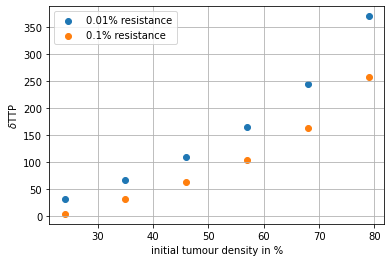

In [305]:
x=np.array([24,35,46,57,68,79])
y=np.array([diff1,diff5,diff6,diff7,diff8,diff2])
y1=np.array([diff3,diff9,diff10,diff11,diff12,diff4])
plt.scatter(x,y,label='0.01% resistance')
plt.scatter(x,y1,label='0.1% resistance')
plt.grid()
plt.legend()
plt.xlabel('initial tumour density in %')
plt.ylabel('$\delta$TTP')
plt.savefig('plot.png')

# Figure 3

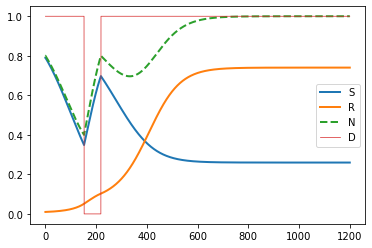

In [336]:
# turnover = 0 ; cost = 0
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.79,
        'growth_rate_R': 0.027,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S1, R1, N1, T1, D1 = ode_model(parameters, verbose=False)

    plt.plot(T1, S1, label='S',linewidth=2)
    plt.plot(T1, R1, label='R',linewidth=2)
    plt.plot(T1, N1, label='N', linestyle='--',linewidth=2)
    plt.plot(T1, D1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    

In [268]:
# compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D)):
    if S1[i] + R1[i] > threshold * (S1[0] + R1[0]):
        ttpa = i
        break
        
print('ttp is', T1[ttpa])

ttp is 413.3000000000255


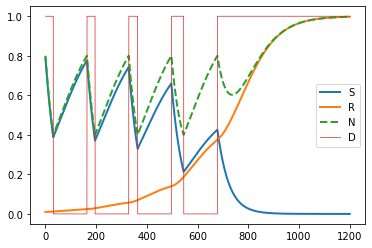

In [337]:
# turnover 50 cost 0
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.79,
        'growth_rate_R': 0.027,
        'carrying_capacity': 2.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0135,
        'death_rate_R': 0.0135,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S2, R2, N2, T2, D2 = ode_model(parameters, verbose=False)
    plt.plot(T2, S2, label='S',linewidth=2)
    plt.plot(T2, R2, label='R',linewidth=2)
    plt.plot(T2, N2, label='N', linestyle='--',linewidth=2)
    plt.plot(T2, D2, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(D2)):
    if Sc2[i] + Rc2[i] > threshold * (Sc2[0] + Rc2[0]):
        ttpc = i
        break
        
#diff1=T2[ttpa]-Tc1[ttpc]
#print('ttpc is', Tc1[ttpc])
#print('ttp difference is', diff1)

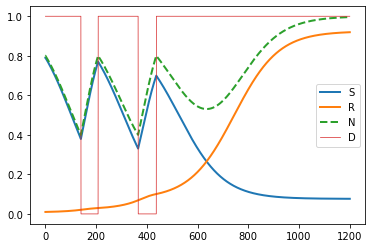

In [338]:
# turnover 0 cost 50
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.79,
        'growth_rate_R': 0.0135,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S3, R3, N3, T3, D3 = ode_model(parameters, verbose=False)
    plt.plot(T3, S3, label='S',linewidth=2)
    plt.plot(T3, R3, label='R',linewidth=2)
    plt.plot(T3, N3, label='N', linestyle='--',linewidth=2)
    plt.plot(T3, D3, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(D3)):
    if S3[i] + R3[i] > threshold * (S3[0] + R3[0]):
        ttpc = i
        break
        
#diff1=T1[ttpa]-Tc1[ttpc]
#print('ttpc is', Tc1[ttpc])
#print('ttp difference is', diff1)

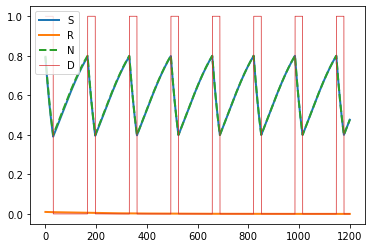

In [339]:
# turnover 50 cost 50
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.79,
        'growth_rate_R': 0.0135,
        'carrying_capacity': 2.,
        'maximum_tollerated_dose': 2.,
        'death_rate_S': 0.0135,
        'death_rate_R': 0.0135,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S4, R4, N4, T4, D4 = ode_model(parameters, verbose=False)
    plt.plot(T4, S4, label='S',linewidth=2)
    plt.plot(T4, R4, label='R',linewidth=2)
    plt.plot(T4, N4, label='N', linestyle='--',linewidth=2)
    plt.plot(T4, D4, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(D4)):
    if S4[i] + R4[i] > threshold * (S4[0] + R4[0]):
        ttpc = i
        break
        
#diff1=T1[ttpa]-Tc1[ttpc]
#print('ttpc is', Tc1[ttpc])
#print('ttp difference is', diff1)

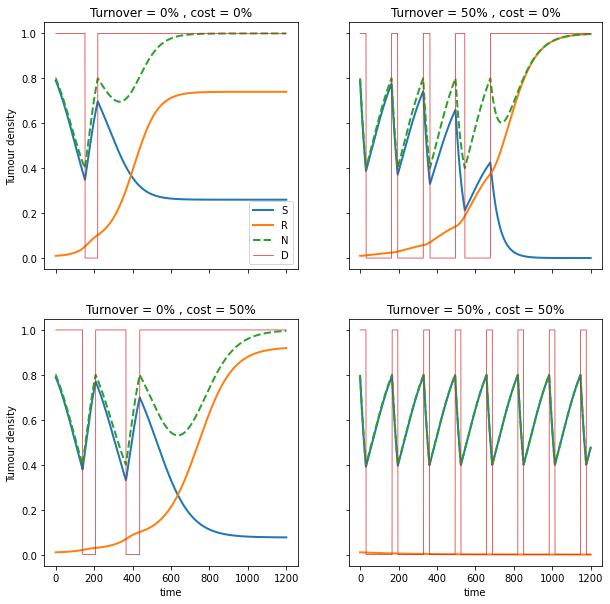

In [343]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(T1, S1, label='S',linewidth=2)
axs[0, 0].plot(T1, R1, label='R',linewidth=2)
axs[0, 0].plot(T1, N1, label='N', linestyle='--',linewidth=2)
axs[0, 0].plot(T1, D1, label='D',linewidth=.7)
axs[0, 0].legend()
axs[0, 0].set_title('Turnover = 0% , cost = 0%')
axs[0, 1].plot(T2, S2, label='S',linewidth=2)
axs[0, 1].plot(T2, R2, label='R',linewidth=2)
axs[0, 1].plot(T2, N2, label='N', linestyle='--',linewidth=2)
axs[0, 1].plot(T2, D2, label='D',linewidth=.7)
axs[0, 1].set_title('Turnover = 50% , cost = 0%')
axs[1, 0].plot(T3, S3, label='S',linewidth=2)
axs[1, 0].plot(T3, R3, label='R',linewidth=2)
axs[1, 0].plot(T3, N3, label='N', linestyle='--',linewidth=2)
axs[1, 0].plot(T3, D3, label='D',linewidth=.7)
axs[1, 0].set_title('Turnover = 0% , cost = 50%')
axs[1, 1].plot(T4, S4, label='S',linewidth=2)
axs[1, 1].plot(T4, R4, label='R',linewidth=2)
axs[1, 1].plot(T4, N4, label='N', linestyle='--',linewidth=2)
axs[1, 1].plot(T4, D4, label='D',linewidth=.7)
axs[1, 1].set_title('Turnover = 50% , cost = 50%')
fig.set_figheight(10)
fig.set_figwidth(10)
#fig, axs = plt.subplots(2, 2, figsize=(30,30))

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='Tumour density')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


plt.savefig('turnover_cost.png')

# Figure 4

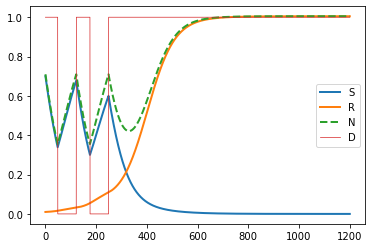

ttp is 484.6000000000417


In [402]:
 # turnover = 25% ; cost = 0 ; density - high; f_R - low
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.7,
        'growth_rate_R': 0.027,
        'carrying_capacity': 1.34,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00675,
        'death_rate_R': 0.00675,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S1, R1, N1, T1, D1 = ode_model(parameters, verbose=False)

    plt.plot(T1, S1, label='S',linewidth=2)
    plt.plot(T1, R1, label='R',linewidth=2)
    plt.plot(T1, N1, label='N', linestyle='--',linewidth=2)
    plt.plot(T1, D1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D1)):
    if S1[i] + R1[i] > threshold * (S1[0] + R1[0]):
        ttpa = i
        break
        
print('ttp is', T1[ttpa])

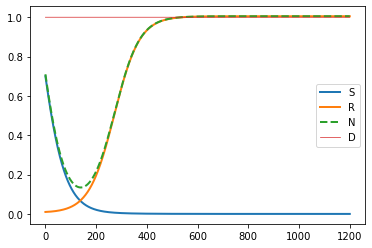

ttpc is 356.40000000001254
ttp difference is 128.20000000002915


In [403]:
#Continuous therapy
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.7,
        'growth_rate_R': 0.027,
        'carrying_capacity': 1.34,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00675,
        'death_rate_R': 0.00675,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc1, Rc1, Nc1, Tc1, Dc1 = ode_model(parameters, verbose=False)
    plt.plot(Tc1, Sc1, label='S',linewidth=2)
    plt.plot(Tc1, Rc1, label='R',linewidth=2)
    plt.plot(Tc1, Nc1, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc1, Dc1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(Dc1)):
    if Sc1[i] + Rc1[i] > threshold * (Sc1[0] + Rc1[0]):
        ttpc = i
        break
        
diff1=T1[ttpa]-Tc1[ttpc]
print('ttpc is', Tc1[ttpc])
print('ttp difference is', diff1)

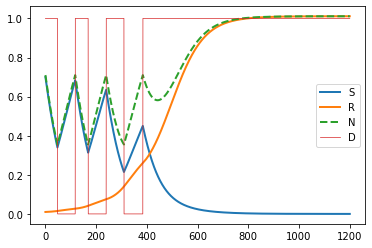

ttp is 581.8000000000637


In [404]:
 # turnover = 25% ; cost = 10% ; density - high; f_R - low
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.7,
        'growth_rate_R': 0.0243,
        'carrying_capacity': 1.4,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00675,
        'death_rate_R': 0.00675,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S1, R1, N1, T1, D1 = ode_model(parameters, verbose=False)

    plt.plot(T1, S1, label='S',linewidth=2)
    plt.plot(T1, R1, label='R',linewidth=2)
    plt.plot(T1, N1, label='N', linestyle='--',linewidth=2)
    plt.plot(T1, D1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D1)):
    if S1[i] + R1[i] > threshold * (S1[0] + R1[0]):
        ttpa = i
        break
        
print('ttp is', T1[ttpa])

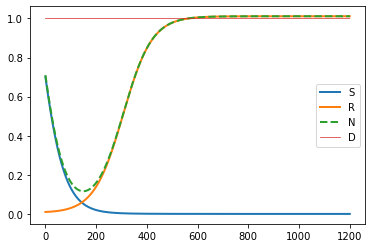

ttpc is 401.5000000000228
ttp difference is 180.30000000004094


In [405]:
#Continuous therapy
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.7,
        'growth_rate_R': 0.0243,
        'carrying_capacity': 1.4,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00675,
        'death_rate_R': 0.00675,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc1, Rc1, Nc1, Tc1, Dc1 = ode_model(parameters, verbose=False)
    plt.plot(Tc1, Sc1, label='S',linewidth=2)
    plt.plot(Tc1, Rc1, label='R',linewidth=2)
    plt.plot(Tc1, Nc1, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc1, Dc1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(Dc1)):
    if Sc1[i] + Rc1[i] > threshold * (Sc1[0] + Rc1[0]):
        ttpc = i
        break
        
diff2=T1[ttpa]-Tc1[ttpc]
print('ttpc is', Tc1[ttpc])
print('ttp difference is', diff2)

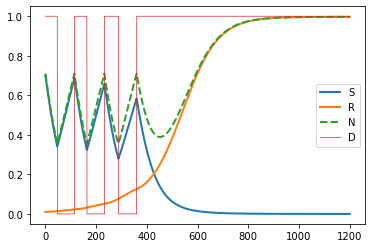

ttp is 656.7000000000808


In [406]:
 # turnover = 25% ; cost = 20% ; density - high; f_R - low
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.7,
        'growth_rate_R': 0.0216,
        'carrying_capacity': 1.45,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00675,
        'death_rate_R': 0.00675,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S1, R1, N1, T1, D1 = ode_model(parameters, verbose=False)

    plt.plot(T1, S1, label='S',linewidth=2)
    plt.plot(T1, R1, label='R',linewidth=2)
    plt.plot(T1, N1, label='N', linestyle='--',linewidth=2)
    plt.plot(T1, D1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D1)):
    if S1[i] + R1[i] > threshold * (S1[0] + R1[0]):
        ttpa = i
        break
        
print('ttp is', T1[ttpa])

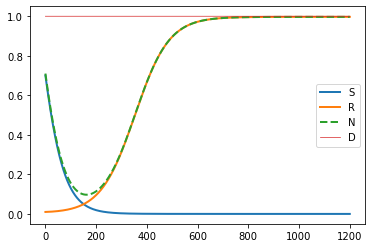

ttpc is 472.0000000000388
ttp difference is 184.70000000004194


In [407]:
#Continuous therapy
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.7,
        'growth_rate_R': 0.0216,
        'carrying_capacity': 1.45,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00675,
        'death_rate_R': 0.00675,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc1, Rc1, Nc1, Tc1, Dc1 = ode_model(parameters, verbose=False)
    plt.plot(Tc1, Sc1, label='S',linewidth=2)
    plt.plot(Tc1, Rc1, label='R',linewidth=2)
    plt.plot(Tc1, Nc1, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc1, Dc1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(Dc1)):
    if Sc1[i] + Rc1[i] > threshold * (Sc1[0] + Rc1[0]):
        ttpc = i
        break
        
diff3=T1[ttpa]-Tc1[ttpc]
print('ttpc is', Tc1[ttpc])
print('ttp difference is', diff3)

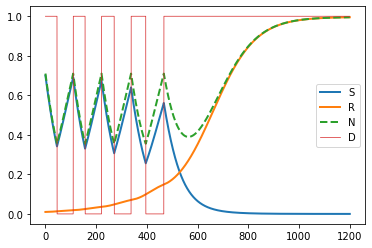

ttp is 802.4000000001139


In [408]:
# turnover = 25% ; cost = 30% ; density - high; f_R - low
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.7,
        'growth_rate_R': 0.0189,
        'carrying_capacity': 1.55,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00675,
        'death_rate_R': 0.00675,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S1, R1, N1, T1, D1 = ode_model(parameters, verbose=False)

    plt.plot(T1, S1, label='S',linewidth=2)
    plt.plot(T1, R1, label='R',linewidth=2)
    plt.plot(T1, N1, label='N', linestyle='--',linewidth=2)
    plt.plot(T1, D1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D1)):
    if S1[i] + R1[i] > threshold * (S1[0] + R1[0]):
        ttpa = i
        break
        
print('ttp is', T1[ttpa])

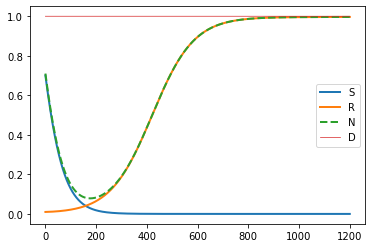

ttpc is 566.5000000000603
ttp difference is 235.90000000005364


In [409]:
#Continuous therapy
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.7,
        'growth_rate_R': 0.0189,
        'carrying_capacity': 1.55,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00675,
        'death_rate_R': 0.00675,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc1, Rc1, Nc1, Tc1, Dc1 = ode_model(parameters, verbose=False)
    plt.plot(Tc1, Sc1, label='S',linewidth=2)
    plt.plot(Tc1, Rc1, label='R',linewidth=2)
    plt.plot(Tc1, Nc1, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc1, Dc1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(Dc1)):
    if Sc1[i] + Rc1[i] > threshold * (Sc1[0] + Rc1[0]):
        ttpc = i
        break
        
diff4=T1[ttpa]-Tc1[ttpc]
print('ttpc is', Tc1[ttpc])
print('ttp difference is', diff4)

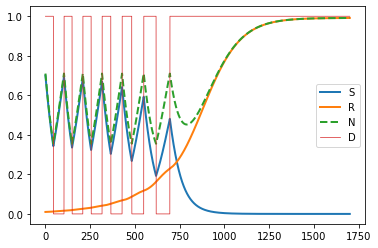

ttp is 1058.300000000133


In [410]:
# turnover = 25% ; cost = 40% ; density - high; f_R - low
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1700,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.7,
        'growth_rate_R': 0.0162,
        'carrying_capacity': 1.7,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00675,
        'death_rate_R': 0.00675,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S1, R1, N1, T1, D1 = ode_model(parameters, verbose=False)

    plt.plot(T1, S1, label='S',linewidth=2)
    plt.plot(T1, R1, label='R',linewidth=2)
    plt.plot(T1, N1, label='N', linestyle='--',linewidth=2)
    plt.plot(T1, D1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D1)):
    if S1[i] + R1[i] > threshold * (S1[0] + R1[0]):
        ttpa = i
        break
        
print('ttp is', T1[ttpa])

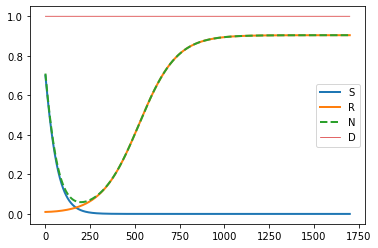

ttpc is 817.7000000001174
ttp difference is 240.6000000000156


In [411]:
#Continuous therapy
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1700,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.7,
        'growth_rate_R': 0.0162,
        'carrying_capacity': 1.55,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00675,
        'death_rate_R': 0.00675,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc1, Rc1, Nc1, Tc1, Dc1 = ode_model(parameters, verbose=False)
    plt.plot(Tc1, Sc1, label='S',linewidth=2)
    plt.plot(Tc1, Rc1, label='R',linewidth=2)
    plt.plot(Tc1, Nc1, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc1, Dc1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(Dc1)):
    if Sc1[i] + Rc1[i] > threshold * (Sc1[0] + Rc1[0]):
        ttpc = i
        break
        
diff5=T1[ttpa]-Tc1[ttpc]
print('ttpc is', Tc1[ttpc])
print('ttp difference is', diff5)

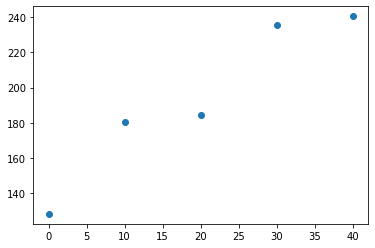

In [413]:
x=np.array([0,10,20,30,40])
y=np.array([diff1,diff2,diff3,diff4,diff5])
plt.scatter(x,y)

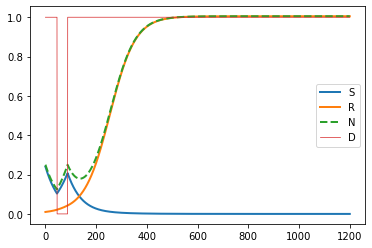

ttp is 204.0999999999927


In [414]:
 # turnover = 25% ; cost = 0 ; density - low; f_R - low
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.027,
        'carrying_capacity': 1.34,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00675,
        'death_rate_R': 0.00675,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S1, R1, N1, T1, D1 = ode_model(parameters, verbose=False)

    plt.plot(T1, S1, label='S',linewidth=2)
    plt.plot(T1, R1, label='R',linewidth=2)
    plt.plot(T1, N1, label='N', linestyle='--',linewidth=2)
    plt.plot(T1, D1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D1)):
    if S1[i] + R1[i] > threshold * (S1[0] + R1[0]):
        ttpa = i
        break
        
print('ttp is', T1[ttpa])

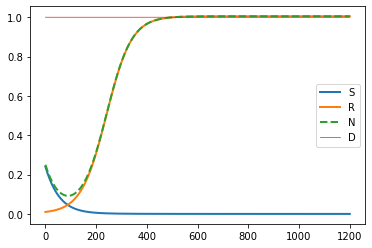

ttpc is 196.59999999999312
ttp difference is 7.499999999999574


In [415]:
#Continuous therapy
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.027,
        'carrying_capacity': 1.34,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00675,
        'death_rate_R': 0.00675,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc1, Rc1, Nc1, Tc1, Dc1 = ode_model(parameters, verbose=False)
    plt.plot(Tc1, Sc1, label='S',linewidth=2)
    plt.plot(Tc1, Rc1, label='R',linewidth=2)
    plt.plot(Tc1, Nc1, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc1, Dc1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(Dc1)):
    if Sc1[i] + Rc1[i] > threshold * (Sc1[0] + Rc1[0]):
        ttpc = i
        break
        
diff11=T1[ttpa]-Tc1[ttpc]
print('ttpc is', Tc1[ttpc])
print('ttp difference is', diff11)

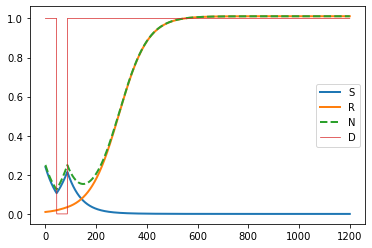

ttp is 235.29999999999092


In [416]:
 # turnover = 25% ; cost = 10% ; density - high; f_R - low
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.0243,
        'carrying_capacity': 1.4,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00675,
        'death_rate_R': 0.00675,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S1, R1, N1, T1, D1 = ode_model(parameters, verbose=False)

    plt.plot(T1, S1, label='S',linewidth=2)
    plt.plot(T1, R1, label='R',linewidth=2)
    plt.plot(T1, N1, label='N', linestyle='--',linewidth=2)
    plt.plot(T1, D1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D1)):
    if S1[i] + R1[i] > threshold * (S1[0] + R1[0]):
        ttpa = i
        break
        
print('ttp is', T1[ttpa])

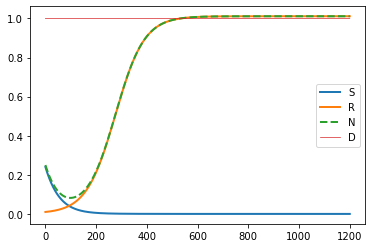

ttpc is 225.29999999999148
ttp difference is 9.999999999999432


In [417]:
#Continuous therapy
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.0243,
        'carrying_capacity': 1.4,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00675,
        'death_rate_R': 0.00675,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc1, Rc1, Nc1, Tc1, Dc1 = ode_model(parameters, verbose=False)
    plt.plot(Tc1, Sc1, label='S',linewidth=2)
    plt.plot(Tc1, Rc1, label='R',linewidth=2)
    plt.plot(Tc1, Nc1, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc1, Dc1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(Dc1)):
    if Sc1[i] + Rc1[i] > threshold * (Sc1[0] + Rc1[0]):
        ttpc = i
        break
        
diff22=T1[ttpa]-Tc1[ttpc]
print('ttpc is', Tc1[ttpc])
print('ttp difference is', diff22)

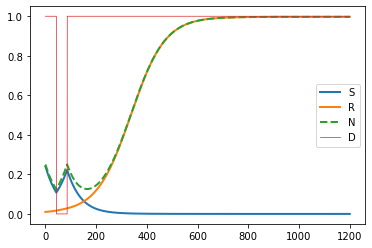

ttp is 277.19999999999453


In [418]:
 # turnover = 25% ; cost = 20% ; density - high; f_R - low
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.0216,
        'carrying_capacity': 1.45,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00675,
        'death_rate_R': 0.00675,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S1, R1, N1, T1, D1 = ode_model(parameters, verbose=False)

    plt.plot(T1, S1, label='S',linewidth=2)
    plt.plot(T1, R1, label='R',linewidth=2)
    plt.plot(T1, N1, label='N', linestyle='--',linewidth=2)
    plt.plot(T1, D1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D1)):
    if S1[i] + R1[i] > threshold * (S1[0] + R1[0]):
        ttpa = i
        break
        
print('ttp is', T1[ttpa])

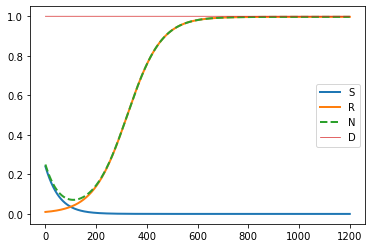

ttpc is 265.0999999999918
ttp difference is 12.100000000002751


In [419]:
#Continuous therapy
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.0216,
        'carrying_capacity': 1.45,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00675,
        'death_rate_R': 0.00675,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc1, Rc1, Nc1, Tc1, Dc1 = ode_model(parameters, verbose=False)
    plt.plot(Tc1, Sc1, label='S',linewidth=2)
    plt.plot(Tc1, Rc1, label='R',linewidth=2)
    plt.plot(Tc1, Nc1, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc1, Dc1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(Dc1)):
    if Sc1[i] + Rc1[i] > threshold * (Sc1[0] + Rc1[0]):
        ttpc = i
        break
        
diff33=T1[ttpa]-Tc1[ttpc]
print('ttpc is', Tc1[ttpc])
print('ttp difference is', diff33)

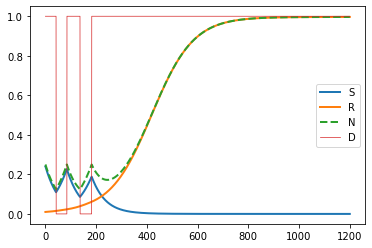

ttp is 344.20000000000977


In [421]:
# turnover = 25% ; cost = 30% ; density - high; f_R - low
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.0189,
        'carrying_capacity': 1.55,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00675,
        'death_rate_R': 0.00675,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S1, R1, N1, T1, D1 = ode_model(parameters, verbose=False)

    plt.plot(T1, S1, label='S',linewidth=2)
    plt.plot(T1, R1, label='R',linewidth=2)
    plt.plot(T1, N1, label='N', linestyle='--',linewidth=2)
    plt.plot(T1, D1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D1)):
    if S1[i] + R1[i] > threshold * (S1[0] + R1[0]):
        ttpa = i
        break
        
print('ttp is', T1[ttpa])

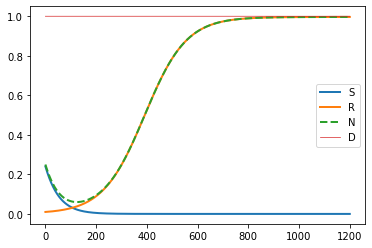

ttpc is 321.4000000000046
ttp difference is 22.800000000005184


In [422]:
#Continuous therapy
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.0189,
        'carrying_capacity': 1.55,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00675,
        'death_rate_R': 0.00675,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc1, Rc1, Nc1, Tc1, Dc1 = ode_model(parameters, verbose=False)
    plt.plot(Tc1, Sc1, label='S',linewidth=2)
    plt.plot(Tc1, Rc1, label='R',linewidth=2)
    plt.plot(Tc1, Nc1, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc1, Dc1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(Dc1)):
    if Sc1[i] + Rc1[i] > threshold * (Sc1[0] + Rc1[0]):
        ttpc = i
        break
        
diff44=T1[ttpa]-Tc1[ttpc]
print('ttpc is', Tc1[ttpc])
print('ttp difference is', diff44)

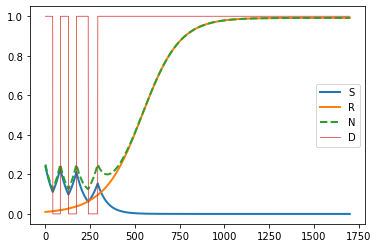

ttp is 444.3000000000325


In [423]:
# turnover = 25% ; cost = 40% ; density - high; f_R - low
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1700,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.0162,
        'carrying_capacity': 1.7,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00675,
        'death_rate_R': 0.00675,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S1, R1, N1, T1, D1 = ode_model(parameters, verbose=False)

    plt.plot(T1, S1, label='S',linewidth=2)
    plt.plot(T1, R1, label='R',linewidth=2)
    plt.plot(T1, N1, label='N', linestyle='--',linewidth=2)
    plt.plot(T1, D1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D1)):
    if S1[i] + R1[i] > threshold * (S1[0] + R1[0]):
        ttpa = i
        break
        
print('ttp is', T1[ttpa])

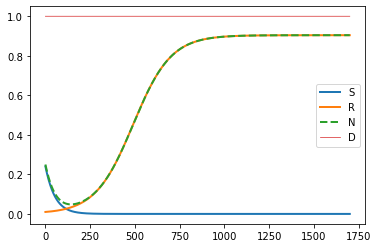

ttpc is 415.700000000026
ttp difference is 28.600000000006503


In [424]:
#Continuous therapy
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1700,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.0162,
        'carrying_capacity': 1.55,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00675,
        'death_rate_R': 0.00675,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc1, Rc1, Nc1, Tc1, Dc1 = ode_model(parameters, verbose=False)
    plt.plot(Tc1, Sc1, label='S',linewidth=2)
    plt.plot(Tc1, Rc1, label='R',linewidth=2)
    plt.plot(Tc1, Nc1, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc1, Dc1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(Dc1)):
    if Sc1[i] + Rc1[i] > threshold * (Sc1[0] + Rc1[0]):
        ttpc = i
        break
        
diff55=T1[ttpa]-Tc1[ttpc]
print('ttpc is', Tc1[ttpc])
print('ttp difference is', diff55)

<function matplotlib.pyplot.show(close=None, block=None)>

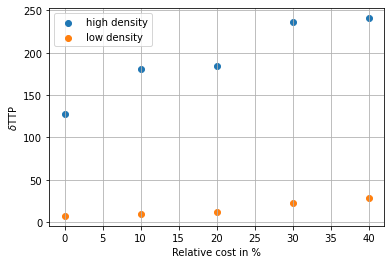

In [427]:
x=np.array([0,10,20,30,40])
y=np.array([diff1,diff2,diff3,diff4,diff5])
y1=np.array([diff11,diff22,diff33,diff44,diff55])
plt.scatter(x,y,label='high density')
plt.scatter(x,y1,label='low density')
plt.grid()
plt.legend()
plt.xlabel('Relative cost in %')
plt.ylabel('$\delta$TTP')
plt.title('How cost affects TTP')
#plt.savefig('plot2.png')
plt.show

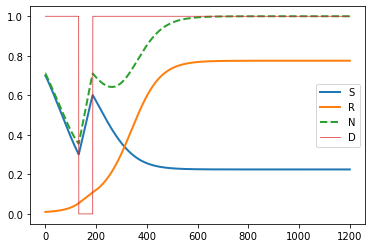

ttp is 399.4000000000223


In [428]:
 # turnover = 0% ; cost = 0 ; density - high; f_R - low
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.7,
        'growth_rate_R': 0.027,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S1, R1, N1, T1, D1 = ode_model(parameters, verbose=False)

    plt.plot(T1, S1, label='S',linewidth=2)
    plt.plot(T1, R1, label='R',linewidth=2)
    plt.plot(T1, N1, label='N', linestyle='--',linewidth=2)
    plt.plot(T1, D1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D1)):
    if S1[i] + R1[i] > threshold * (S1[0] + R1[0]):
        ttpa = i
        break
        
print('ttp is', T1[ttpa])

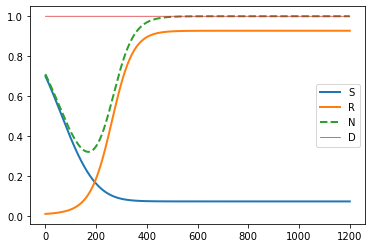

ttpc is 327.80000000000604
ttp difference is 71.60000000001628


In [430]:
#Continuous therapy
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.7,
        'growth_rate_R': 0.027,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00,
        'death_rate_R': 0.00,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc1, Rc1, Nc1, Tc1, Dc1 = ode_model(parameters, verbose=False)
    plt.plot(Tc1, Sc1, label='S',linewidth=2)
    plt.plot(Tc1, Rc1, label='R',linewidth=2)
    plt.plot(Tc1, Nc1, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc1, Dc1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(Dc1)):
    if Sc1[i] + Rc1[i] > threshold * (Sc1[0] + Rc1[0]):
        ttpc = i
        break
        
diff111=T1[ttpa]-Tc1[ttpc]
print('ttpc is', Tc1[ttpc])
print('ttp difference is', diff111)

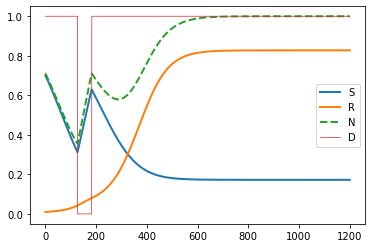

ttp is 439.50000000003143


In [432]:
 # turnover = 0% ; cost = 10% ; density - high; f_R - low
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.7,
        'growth_rate_R': 0.0243,
        'carrying_capacity': 1,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0,
        'death_rate_R': 0.0,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S1, R1, N1, T1, D1 = ode_model(parameters, verbose=False)

    plt.plot(T1, S1, label='S',linewidth=2)
    plt.plot(T1, R1, label='R',linewidth=2)
    plt.plot(T1, N1, label='N', linestyle='--',linewidth=2)
    plt.plot(T1, D1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D1)):
    if S1[i] + R1[i] > threshold * (S1[0] + R1[0]):
        ttpa = i
        break
        
print('ttp is', T1[ttpa])

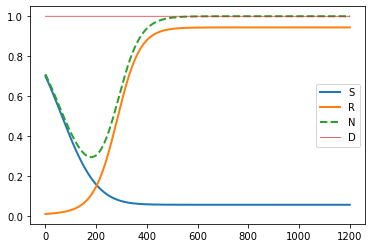

ttpc is 355.3000000000123
ttp difference is 84.20000000001914


In [433]:
#Continuous therapy
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.7,
        'growth_rate_R': 0.0243,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00,
        'death_rate_R': 0.00,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc1, Rc1, Nc1, Tc1, Dc1 = ode_model(parameters, verbose=False)
    plt.plot(Tc1, Sc1, label='S',linewidth=2)
    plt.plot(Tc1, Rc1, label='R',linewidth=2)
    plt.plot(Tc1, Nc1, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc1, Dc1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(Dc1)):
    if Sc1[i] + Rc1[i] > threshold * (Sc1[0] + Rc1[0]):
        ttpc = i
        break
        
diff222=T1[ttpa]-Tc1[ttpc]
print('ttpc is', Tc1[ttpc])
print('ttp difference is', diff222)

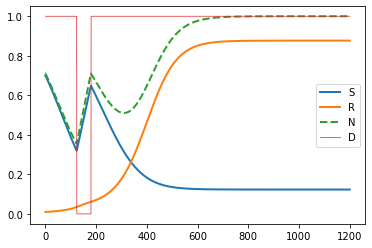

ttp is 480.40000000004073


In [434]:
 # turnover = 0% ; cost = 20% ; density - high; f_R - low
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.7,
        'growth_rate_R': 0.0216,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00,
        'death_rate_R': 0.00,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S1, R1, N1, T1, D1 = ode_model(parameters, verbose=False)

    plt.plot(T1, S1, label='S',linewidth=2)
    plt.plot(T1, R1, label='R',linewidth=2)
    plt.plot(T1, N1, label='N', linestyle='--',linewidth=2)
    plt.plot(T1, D1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D1)):
    if S1[i] + R1[i] > threshold * (S1[0] + R1[0]):
        ttpa = i
        break
        
print('ttp is', T1[ttpa])

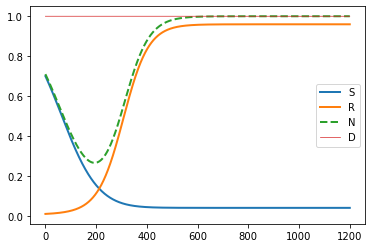

ttpc is 389.00000000001995
ttp difference is 91.40000000002078


In [435]:
#Continuous therapy
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.7,
        'growth_rate_R': 0.0216,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00,
        'death_rate_R': 0.00,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc1, Rc1, Nc1, Tc1, Dc1 = ode_model(parameters, verbose=False)
    plt.plot(Tc1, Sc1, label='S',linewidth=2)
    plt.plot(Tc1, Rc1, label='R',linewidth=2)
    plt.plot(Tc1, Nc1, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc1, Dc1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(Dc1)):
    if Sc1[i] + Rc1[i] > threshold * (Sc1[0] + Rc1[0]):
        ttpc = i
        break
        
diff333=T1[ttpa]-Tc1[ttpc]
print('ttpc is', Tc1[ttpc])
print('ttp difference is', diff333)

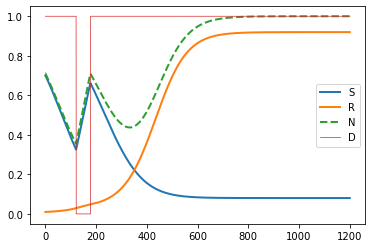

ttp is 526.8000000000512


In [436]:
# turnover = 0% ; cost = 30% ; density - high; f_R - low
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.7,
        'growth_rate_R': 0.0189,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00,
        'death_rate_R': 0.00,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S1, R1, N1, T1, D1 = ode_model(parameters, verbose=False)

    plt.plot(T1, S1, label='S',linewidth=2)
    plt.plot(T1, R1, label='R',linewidth=2)
    plt.plot(T1, N1, label='N', linestyle='--',linewidth=2)
    plt.plot(T1, D1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D1)):
    if S1[i] + R1[i] > threshold * (S1[0] + R1[0]):
        ttpa = i
        break
        
print('ttp is', T1[ttpa])

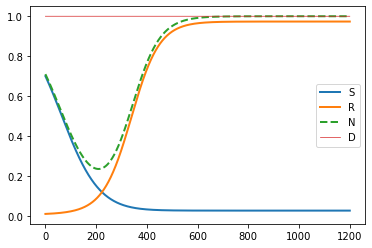

ttpc is 431.70000000002966
ttp difference is 95.10000000002157


In [438]:
#Continuous therapy
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.7,
        'growth_rate_R': 0.0189,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00,
        'death_rate_R': 0.00,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc1, Rc1, Nc1, Tc1, Dc1 = ode_model(parameters, verbose=False)
    plt.plot(Tc1, Sc1, label='S',linewidth=2)
    plt.plot(Tc1, Rc1, label='R',linewidth=2)
    plt.plot(Tc1, Nc1, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc1, Dc1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(Dc1)):
    if Sc1[i] + Rc1[i] > threshold * (Sc1[0] + Rc1[0]):
        ttpc = i
        break
        
diff444=T1[ttpa]-Tc1[ttpc]
print('ttpc is', Tc1[ttpc])
print('ttp difference is', diff444)

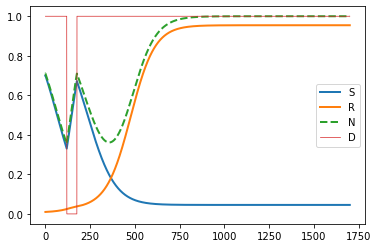

ttp is 584.4000000000643


In [439]:
# turnover = 0% ; cost = 40% ; density - high; f_R - low
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1700,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.7,
        'growth_rate_R': 0.0162,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00,
        'death_rate_R': 0.00,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S1, R1, N1, T1, D1 = ode_model(parameters, verbose=False)

    plt.plot(T1, S1, label='S',linewidth=2)
    plt.plot(T1, R1, label='R',linewidth=2)
    plt.plot(T1, N1, label='N', linestyle='--',linewidth=2)
    plt.plot(T1, D1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D1)):
    if S1[i] + R1[i] > threshold * (S1[0] + R1[0]):
        ttpa = i
        break
        
print('ttp is', T1[ttpa])

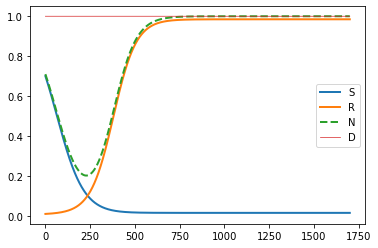

ttpc is 488.00000000004246
ttp difference is 96.40000000002186


In [440]:
#Continuous therapy
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1700,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.7,
        'growth_rate_R': 0.0162,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00,
        'death_rate_R': 0.00,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc1, Rc1, Nc1, Tc1, Dc1 = ode_model(parameters, verbose=False)
    plt.plot(Tc1, Sc1, label='S',linewidth=2)
    plt.plot(Tc1, Rc1, label='R',linewidth=2)
    plt.plot(Tc1, Nc1, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc1, Dc1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(Dc1)):
    if Sc1[i] + Rc1[i] > threshold * (Sc1[0] + Rc1[0]):
        ttpc = i
        break
        
diff555=T1[ttpa]-Tc1[ttpc]
print('ttpc is', Tc1[ttpc])
print('ttp difference is', diff555)

<function matplotlib.pyplot.show(close=None, block=None)>

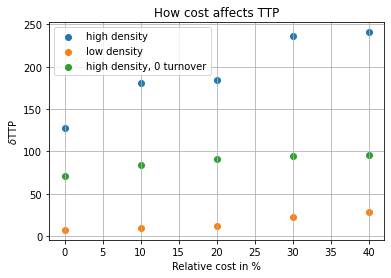

In [442]:
x=np.array([0,10,20,30,40])
y=np.array([diff1,diff2,diff3,diff4,diff5])
y1=np.array([diff11,diff22,diff33,diff44,diff55])
y2=np.array([diff111,diff222,diff333,diff444,diff555])
plt.scatter(x,y,label='high density')
plt.scatter(x,y1,label='low density')
plt.scatter(x,y2,label='high density, 0 turnover')
plt.grid()
plt.legend()
plt.xlabel('Relative cost in %')
plt.ylabel('$\delta$TTP')
plt.title('How cost affects TTP')
#plt.savefig('plot2.png')
plt.show

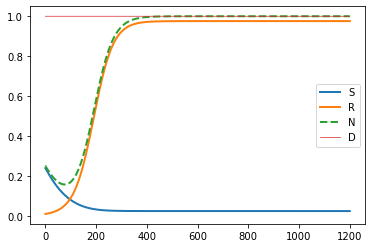

ttp is 148.79999999999583


In [443]:
 # turnover = 0% ; cost = 0 ; density - low; f_R - low
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.027,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00,
        'death_rate_R': 0.00,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S1, R1, N1, T1, D1 = ode_model(parameters, verbose=False)

    plt.plot(T1, S1, label='S',linewidth=2)
    plt.plot(T1, R1, label='R',linewidth=2)
    plt.plot(T1, N1, label='N', linestyle='--',linewidth=2)
    plt.plot(T1, D1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D1)):
    if S1[i] + R1[i] > threshold * (S1[0] + R1[0]):
        ttpa = i
        break
        
print('ttp is', T1[ttpa])

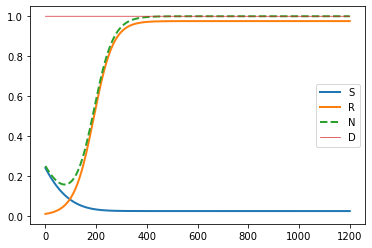

ttpc is 148.79999999999583
ttp difference is 0.0


In [444]:
#Continuous therapy
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.027,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00,
        'death_rate_R': 0.00,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc1, Rc1, Nc1, Tc1, Dc1 = ode_model(parameters, verbose=False)
    plt.plot(Tc1, Sc1, label='S',linewidth=2)
    plt.plot(Tc1, Rc1, label='R',linewidth=2)
    plt.plot(Tc1, Nc1, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc1, Dc1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(Dc1)):
    if Sc1[i] + Rc1[i] > threshold * (Sc1[0] + Rc1[0]):
        ttpc = i
        break
        
diff1111=T1[ttpa]-Tc1[ttpc]
print('ttpc is', Tc1[ttpc])
print('ttp difference is', diff1111)

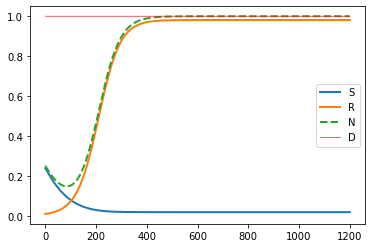

ttp is 165.79999999999487


In [445]:
 # turnover = 0% ; cost = 10% ; density - high; f_R - low
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.0243,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00,
        'death_rate_R': 0.00,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S1, R1, N1, T1, D1 = ode_model(parameters, verbose=False)

    plt.plot(T1, S1, label='S',linewidth=2)
    plt.plot(T1, R1, label='R',linewidth=2)
    plt.plot(T1, N1, label='N', linestyle='--',linewidth=2)
    plt.plot(T1, D1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D1)):
    if S1[i] + R1[i] > threshold * (S1[0] + R1[0]):
        ttpa = i
        break
        
print('ttp is', T1[ttpa])

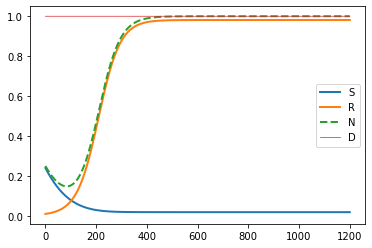

ttpc is 165.69999999999487
ttp difference is 0.09999999999999432


In [446]:
#Continuous therapy
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.0243,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00,
        'death_rate_R': 0.00,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc1, Rc1, Nc1, Tc1, Dc1 = ode_model(parameters, verbose=False)
    plt.plot(Tc1, Sc1, label='S',linewidth=2)
    plt.plot(Tc1, Rc1, label='R',linewidth=2)
    plt.plot(Tc1, Nc1, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc1, Dc1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(Dc1)):
    if Sc1[i] + Rc1[i] > threshold * (Sc1[0] + Rc1[0]):
        ttpc = i
        break
        
diff2222=T1[ttpa]-Tc1[ttpc]
print('ttpc is', Tc1[ttpc])
print('ttp difference is', diff2222)

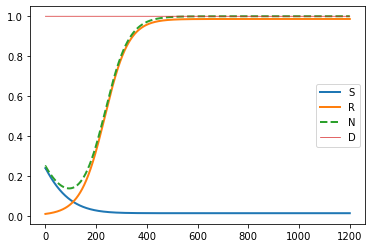

ttp is 186.69999999999368


In [447]:
 # turnover = 0% ; cost = 20% ; density - high; f_R - low
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.0216,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00,
        'death_rate_R': 0.00,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S1, R1, N1, T1, D1 = ode_model(parameters, verbose=False)

    plt.plot(T1, S1, label='S',linewidth=2)
    plt.plot(T1, R1, label='R',linewidth=2)
    plt.plot(T1, N1, label='N', linestyle='--',linewidth=2)
    plt.plot(T1, D1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D1)):
    if S1[i] + R1[i] > threshold * (S1[0] + R1[0]):
        ttpa = i
        break
        
print('ttp is', T1[ttpa])

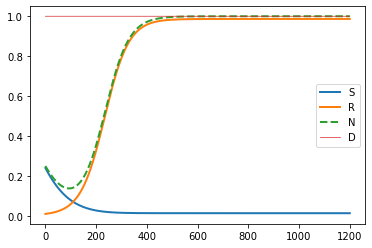

ttpc is 186.69999999999368
ttp difference is 0.0


In [448]:
#Continuous therapy
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.0216,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00,
        'death_rate_R': 0.00,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc1, Rc1, Nc1, Tc1, Dc1 = ode_model(parameters, verbose=False)
    plt.plot(Tc1, Sc1, label='S',linewidth=2)
    plt.plot(Tc1, Rc1, label='R',linewidth=2)
    plt.plot(Tc1, Nc1, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc1, Dc1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(Dc1)):
    if Sc1[i] + Rc1[i] > threshold * (Sc1[0] + Rc1[0]):
        ttpc = i
        break
        
diff3333=T1[ttpa]-Tc1[ttpc]
print('ttpc is', Tc1[ttpc])
print('ttp difference is', diff3333)

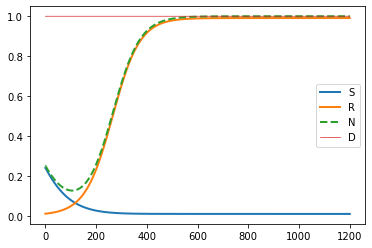

ttp is 213.19999999999217


In [449]:
# turnover = 0% ; cost = 30% ; density - high; f_R - low
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.0189,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00,
        'death_rate_R': 0.00,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S1, R1, N1, T1, D1 = ode_model(parameters, verbose=False)

    plt.plot(T1, S1, label='S',linewidth=2)
    plt.plot(T1, R1, label='R',linewidth=2)
    plt.plot(T1, N1, label='N', linestyle='--',linewidth=2)
    plt.plot(T1, D1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D1)):
    if S1[i] + R1[i] > threshold * (S1[0] + R1[0]):
        ttpa = i
        break
        
print('ttp is', T1[ttpa])

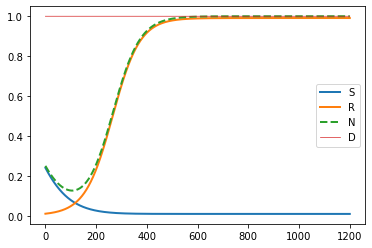

ttpc is 213.19999999999217
ttp difference is 0.0


In [450]:
#Continuous therapy
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1200,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.0189,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00,
        'death_rate_R': 0.00,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc1, Rc1, Nc1, Tc1, Dc1 = ode_model(parameters, verbose=False)
    plt.plot(Tc1, Sc1, label='S',linewidth=2)
    plt.plot(Tc1, Rc1, label='R',linewidth=2)
    plt.plot(Tc1, Nc1, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc1, Dc1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(Dc1)):
    if Sc1[i] + Rc1[i] > threshold * (Sc1[0] + Rc1[0]):
        ttpc = i
        break
        
diff4444=T1[ttpa]-Tc1[ttpc]
print('ttpc is', Tc1[ttpc])
print('ttp difference is', diff4444)

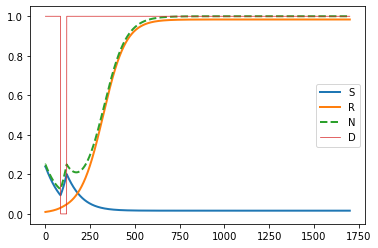

ttp is 250.09999999999008


In [451]:
# turnover = 0% ; cost = 40% ; density - high; f_R - low
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1700,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.0162,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00,
        'death_rate_R': 0.00,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    S1, R1, N1, T1, D1 = ode_model(parameters, verbose=False)

    plt.plot(T1, S1, label='S',linewidth=2)
    plt.plot(T1, R1, label='R',linewidth=2)
    plt.plot(T1, N1, label='N', linestyle='--',linewidth=2)
    plt.plot(T1, D1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpa = 0
threshold=1.2
for i in range(len(D1)):
    if S1[i] + R1[i] > threshold * (S1[0] + R1[0]):
        ttpa = i
        break
        
print('ttp is', T1[ttpa])

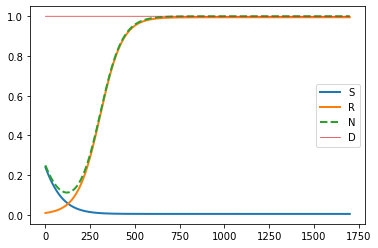

ttpc is 248.0999999999902
ttp difference is 1.9999999999998863


In [452]:
#Continuous therapy
if __name__ == "__main__":

    # Define parameters

    parameters = {     
        'time_end': 1700,
        'time_start': 0,                                  
        'time_step': 0.1,
        'tolerance': 100,
        'R0': 0.01,
        'growth_rate_S': 0.027,
        'S0': 0.24,
        'growth_rate_R': 0.0162,
        'carrying_capacity': 1.,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.00,
        'death_rate_R': 0.00,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 0,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
    }

    # test_parameters(parameters)

    Sc1, Rc1, Nc1, Tc1, Dc1 = ode_model(parameters, verbose=False)
    plt.plot(Tc1, Sc1, label='S',linewidth=2)
    plt.plot(Tc1, Rc1, label='R',linewidth=2)
    plt.plot(Tc1, Nc1, label='N', linestyle='--',linewidth=2)
    plt.plot(Tc1, Dc1, label='D',linewidth=.7)
    plt.legend()
    plt.show()
    
    # compute the time to progression
ttpc = 0
threshold=1.2
for i in range(len(Dc1)):
    if Sc1[i] + Rc1[i] > threshold * (Sc1[0] + Rc1[0]):
        ttpc = i
        break
        
diff5555=T1[ttpa]-Tc1[ttpc]
print('ttpc is', Tc1[ttpc])
print('ttp difference is', diff5555)

<function matplotlib.pyplot.show(close=None, block=None)>

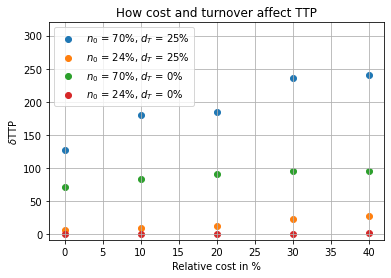

In [465]:
x=np.array([0,10,20,30,40])
y=np.array([diff1,diff2,diff3,diff4,diff5])
y1=np.array([diff11,diff22,diff33,diff44,diff55])
y2=np.array([diff111,diff222,diff333,diff444,diff555])
y3=np.array([diff1111,diff2222,diff3333,diff4444,diff5555])
plt.scatter(x,y,label='$n_0$ = 70%, $d_T$ = 25%')
plt.scatter(x,y1,label='$n_0$ = 24%, $d_T$ = 25%')
plt.scatter(x,y2,label='$n_0$ = 70%, $d_T$ = 0%')
plt.scatter(x,y3,label='$n_0$ = 24%, $d_T$ = 0%')
plt.grid()
plt.legend()
plt.xlabel('Relative cost in %')
plt.ylabel('$\delta$TTP')
plt.title('How cost and turnover affect TTP')
plt.ylim(-8,320)
plt.savefig('plot2.png')
plt.show

# New figure

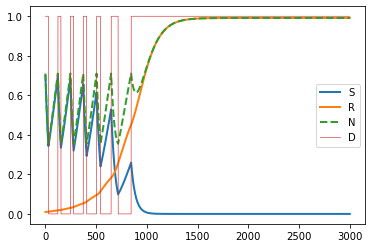

In [486]:
if __name__ == "__main__":

    # Define parameters

    parameters1 = {
        'time_start': 0,                                  
        'time_end': 3000,
        'time_step': .1,
        'tolerance': 100,
        'S0': .7,
        'R0': .01,
        'growth_rate_S': 0.027,
        'growth_rate_R': 0.023,
        'carrying_capacity': 2.4,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0135,
        'death_rate_R': 0.0135,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 1,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,}

    # test_parameters(parameters)

    S1, R1, N1, T1, D1 = ode_model(parameters1, verbose=False)
    plt.plot(T1, S1, label='S',linewidth=2)
    plt.plot(T1, R1, label='R',linewidth=2)
    plt.plot(T1, N1, label='N', linestyle='--',linewidth=2)
    plt.plot(T1, D1, label='D',linewidth=.6)
    plt.legend()
   
    plt.show()
    # compute the time to progression
ttpa1 = 0
threshold=1.2
for i in range(len(T1)):
    if S1[i] + R1[i] > threshold * (S1[0] + R1[0]):
        ttpa1 = i
        break

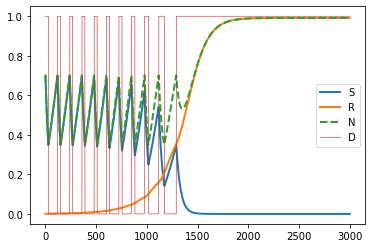

In [488]:
if __name__ == "__main__":

    # Define parameters

    parameters2 = {
        'time_start': 0,                                  
        'time_end': 3000,
        'time_step': .1,
        'tolerance': 100,
        'S0': .7,
        'R0': .001,
        'growth_rate_S': 0.027,
        'growth_rate_R': 0.023,
        'carrying_capacity': 2.4,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0135,
        'death_rate_R': 0.0135,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 1,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,}

    # test_parameters(parameters)

    S2, R2, N2, T2, D2 = ode_model(parameters2, verbose=False)

    plt.plot(T2, S2, label='S',linewidth=2)
    plt.plot(T2, R2, label='R',linewidth=2)
    plt.plot(T2, N2, label='N', linestyle='--',linewidth=2)
    plt.plot(T2, D2, label='D',linewidth=.6)
    plt.legend()
    
    plt.show() 
    # compute the time to progression
ttpa2 = 0
threshold=1.2
for i in range(len(D2)):
    if S2[i] + R2[i] > threshold * (S2[0] + R2[0]):
        ttpa2 = i
        break

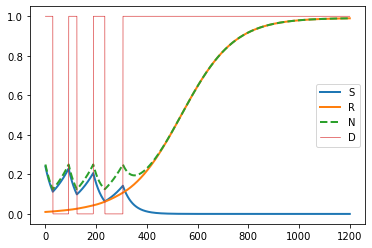

In [479]:
if __name__ == "__main__":

    # Define parameters

    parameters3 = {
        'time_start': 0,                                  
        'time_end': 1200,
        'time_step': .1,
        'tolerance': 100,
        'S0': .24,
        'R0': .01,
        'growth_rate_S': 0.027,
        'growth_rate_R': 0.023,
        'carrying_capacity': 2.4,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0135,
        'death_rate_R': 0.0135,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 1,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
        'drug_rate':0.0008,}

    # test_parameters(parameters)

    S3, R3, N3, T3, D3 = ode_model(parameters3, verbose=False)

    plt.plot(T3, S3, label='S',linewidth=2)
    plt.plot(T3, R3, label='R',linewidth=2)
    plt.plot(T3, N3, label='N', linestyle='--',linewidth=2)
    plt.plot(T3, D3, label='D',linewidth=.6)
    plt.legend()
    
    plt.show() 
    # compute the time to progression
ttpa3 = 0
threshold=1.2
for i in range(len(D3)):
    if S3[i] + R3[i] > threshold * (S3[0] + R3[0]):
        ttpa3 = i
        break

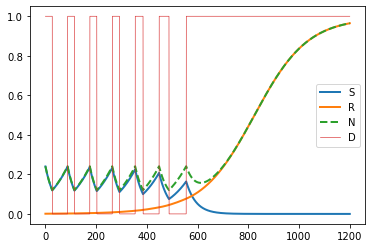

In [490]:
if __name__ == "__main__":

    # Define parameters

    parameters4 = {
        'time_start': 0,                                  
        'time_end': 1200,
        'time_step': .1,
        'tolerance': 100,
        'S0': .24,
        'R0': .001,
        'growth_rate_S': 0.027,
        'growth_rate_R': 0.023,
        'carrying_capacity': 2.4,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0135,
        'death_rate_R': 0.0135,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 1,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
        'drug_rate':0.0008,}

    # test_parameters(parameters)

    S4, R4, N4, T4, D4 = ode_model(parameters4, verbose=False)

    plt.plot(T4, S4, label='S',linewidth=2)
    plt.plot(T4, R4, label='R',linewidth=2)
    plt.plot(T4, N4, label='N', linestyle='--',linewidth=2)
    plt.plot(T4, D4, label='D',linewidth=.6)
    plt.legend()
    plt.savefig('inst_plot.png')
    plt.show() 
    # compute the time to progression
ttpa4 = 0
threshold=1.2
for i in range(len(D4)):
    if S4[i] + R4[i] > threshold * (S4[0] + R4[0]):
        ttpa4 = i
        break
        

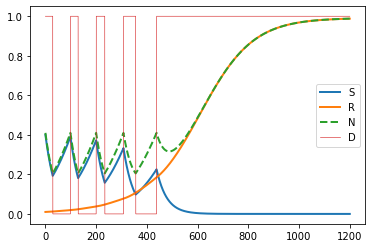

In [481]:
if __name__ == "__main__":

    # Define parameters

    parameters5 = {
        'time_start': 0,                                  
        'time_end': 1200,
        'time_step': .1,
        'tolerance': 100,
        'S0': .4,
        'R0': .01,
        'growth_rate_S': 0.027,
        'growth_rate_R': 0.023,
        'carrying_capacity': 2.4,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0135,
        'death_rate_R': 0.0135,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 1,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
        'drug_rate':0.0008,}

    # test_parameters(parameters)

    S5, R5, N5, T5, D5 = ode_model(parameters5, verbose=False)

    plt.plot(T5, S5, label='S',linewidth=2)
    plt.plot(T5, R5, label='R',linewidth=2)
    plt.plot(T5, N5, label='N', linestyle='--',linewidth=2)
    plt.plot(T5, D5, label='D',linewidth=.6)
    plt.legend()
    
    plt.show() 
    # compute the time to progression
ttpa5 = 0
threshold=1.2
for i in range(len(D5)):
    if S5[i] + R5[i] > threshold * (S5[0] + R5[0]):
        ttpa5 = i
        break

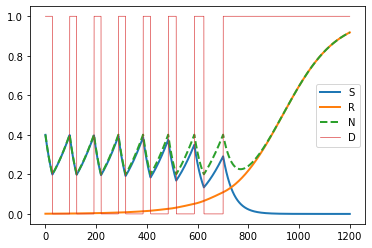

In [482]:
if __name__ == "__main__":

    # Define parameters

    parameters6 = {
        'time_start': 0,                                  
        'time_end': 1200,
        'time_step': .1,
        'tolerance': 100,
        'S0': .4,
        'R0': .001,
        'growth_rate_S': 0.027,
        'growth_rate_R': 0.023,
        'carrying_capacity': 2.4,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0135,
        'death_rate_R': 0.0135,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 1,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
        'drug_rate':0.0008,}

    # test_parameters(parameters)

    S6, R6, N6, T6, D6 = ode_model(parameters6, verbose=False)

    plt.plot(T6, S6, label='S',linewidth=2)
    plt.plot(T6, R6, label='R',linewidth=2)
    plt.plot(T6, N6, label='N', linestyle='--',linewidth=2)
    plt.plot(T6, D6, label='D',linewidth=.6)
    plt.legend()
    
    plt.show() 
    # compute the time to progression
ttpa6 = 0
threshold=1.2
for i in range(len(D5)):
    if S6[i] + R6[i] > threshold * (S6[0] + R6[0]):
        ttpa6 = i
        break

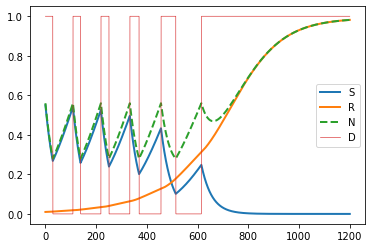

In [495]:
if __name__ == "__main__":

    # Define parameters

    parameters7 = {
        'time_start': 0,                                  
        'time_end': 1200,
        'time_step': .1,
        'tolerance': 100,
        'S0': .55,
        'R0': .01,
        'growth_rate_S': 0.027,
        'growth_rate_R': 0.023,
        'carrying_capacity': 2.4,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0135,
        'death_rate_R': 0.0135,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 1,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
        'drug_rate':0.0008,}

    # test_parameters(parameters)

    S7, R7, N7, T7, D7 = ode_model(parameters7, verbose=False)

    plt.plot(T7, S7, label='S',linewidth=2)
    plt.plot(T7, R7, label='R',linewidth=2)
    plt.plot(T7, N7, label='N', linestyle='--',linewidth=2)
    plt.plot(T7, D7, label='D',linewidth=.6)
    plt.legend()
    
    plt.show() 
    # compute the time to progression
ttpa7 = 0
threshold=1.2
for i in range(len(D7)):
    if S7[i] + R7[i] > threshold * (S7[0] + R7[0]):
        ttpa7 = i
        break

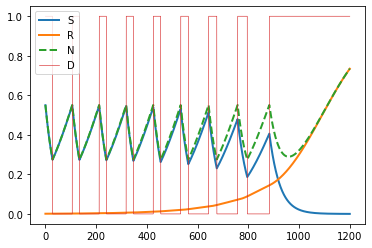

In [484]:
if __name__ == "__main__":

    # Define parameters

    parameters8 = {
        'time_start': 0,                                  
        'time_end': 1200,
        'time_step': .1,
        'tolerance': 100,
        'S0': .55,
        'R0': .001,
        'growth_rate_S': 0.027,
        'growth_rate_R': 0.023,
        'carrying_capacity': 2.4,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.0135,
        'death_rate_R': 0.0135,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 1,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,
        'drug_rate':0.0008,}

    # test_parameters(parameters)

    S8, R8, N8, T8, D8 = ode_model(parameters8, verbose=False)

    plt.plot(T8, S8, label='S',linewidth=2)
    plt.plot(T8, R8, label='R',linewidth=2)
    plt.plot(T8, N8, label='N', linestyle='--',linewidth=2)
    plt.plot(T8, D8, label='D',linewidth=.6)
    plt.legend()
    
    plt.show() 
    # compute the time to progression
ttpa8 = 0
threshold=1.2
for i in range(len(D8)):
    if S8[i] + R8[i] > threshold * (S8[0] + R8[0]):
        ttpa8 = i
        break

In [489]:
print(T1[ttpa1],T2[ttpa2],T3[ttpa3],T4[ttpa4],T5[ttpa5],T6[ttpa6],T7[ttpa7],T8[ttpa8])

1077.5000000001155 1558.6999999996779 443.7000000000324 728.100000000097 602.1000000000683 927.1000000001422 790.1000000001111 1162.1000000000386


In [493]:
print(sum(D1[0:ttpa1]),sum(D2[0:ttpa2]),sum(D3[0:ttpa3]),sum(D4[0:ttpa4]),sum(D5[0:ttpa5]),sum(D6[0:ttpa6]),sum(D7[0:ttpa7]))

4649.0 6007.0 2456.0 3535.0 3051.0 4363.0 3609.0


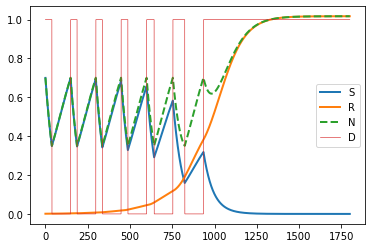

In [518]:
if __name__ == "__main__":

    # Define parameters

    parameters_comp = {
        'time_start': 0,                                  
        'time_end': 1800,
        'time_step': .1,
        'tolerance': 100,
        'S0': .7,
        'R0': .001,
        'growth_rate_S': 0.023,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.8,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.01,
        'death_rate_R': 0.01,
        'division_rate': .75,
        'therapy_type': 'adaptive',
        'current_state': 1,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,}

    # test_parameters(parameters)

    SS, RR, NN, TT, DD = ode_model(parameters_comp, verbose=False)

    plt.plot(TT, SS, label='S',linewidth=2)
    plt.plot(TT, RR, label='R',linewidth=2)
    plt.plot(TT, NN, label='N', linestyle='--',linewidth=2)
    plt.plot(TT, DD, label='D',linewidth=.6)
    plt.legend()
    
    plt.show() 
    # compute the time to progression
ttpaa = 0
threshold=1.25
for i in range(len(DD)):
    if SS[i] + RR[i] > threshold * (SS[0] + RR[0]):
        ttpaa = i
        break

In [519]:
TT[ttpaa]

1146.0000000000532

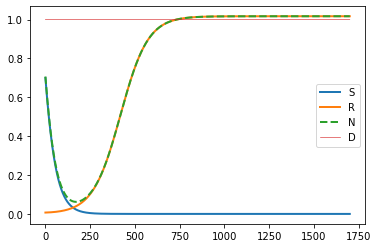

In [520]:
if __name__ == "__main__":

    # Define parameters

    parameters_comp = {
        'time_start': 0,                                  
        'time_end': 1700,
        'time_step': .1,
        'tolerance': 100,
        'S0': .7,
        'R0': .007,
        'growth_rate_S': 0.023,
        'growth_rate_R': 0.023,
        'carrying_capacity': 1.8,
        'maximum_tollerated_dose': 1.,
        'death_rate_S': 0.01,
        'death_rate_R': 0.01,
        'division_rate': .75,
        'therapy_type': 'continuous',
        'current_state': 1,
        'adaptive_therapy_ratio': 1/2,
        'alpha': 0,}

    # test_parameters(parameters)

    SS, RR, NN, TT, DD = ode_model(parameters_comp, verbose=False)

    plt.plot(TT, SS, label='S',linewidth=2)
    plt.plot(TT, RR, label='R',linewidth=2)
    plt.plot(TT, NN, label='N', linestyle='--',linewidth=2)
    plt.plot(TT, DD, label='D',linewidth=.6)
    plt.legend()
    
    plt.show() 
    # compute the time to progression
ttpaa = 0
threshold=1.25
for i in range(len(DD)):
    if SS[i] + RR[i] > threshold * (SS[0] + RR[0]):
        ttpaa = i
        break

In [521]:
TT[ttpaa]

564.4000000000598

In [522]:
(1146-564)/564

1.0319148936170213